 # 시계열 전처리 및 기본 모델링


# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 데이터 불러오기

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/SeoulBike_Simple.csv'
bike = pd.read_csv(path)
bike['Datetime'] = pd.to_datetime(bike['Datetime'] )
bike.rename(columns={'Rented Bike Count':'Count'}, inplace = True)
bike = bike.loc[bike['Datetime'].between('2018-06-11','2018-08-13', inclusive = 'left'),
                ['Datetime', 'Temperature', 'Humidity','Count']]
bike.reset_index(drop = True, inplace = True)

In [3]:
bike.head()

,Datetime,Temperature,Humidity,Count
0,2018-06-11 00:00:00,20.3,58.0,918
1,2018-06-11 01:00:00,19.8,59.0,555
2,2018-06-11 02:00:00,19.2,60.0,353
3,2018-06-11 03:00:00,18.8,61.0,232
4,2018-06-11 04:00:00,18.8,60.0,194


## (3) 데이터 둘러보기

In [4]:
bike.describe(include = 'all')@

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Datetime,1512,1512,2018-06-11,1,2018-06-11,2018-08-12 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,1509.0,NaN,NaT,NaN,NaT,NaT,26.983764,4.75233,16.3,23.2,27.1,30.4,39.4
Humidity,1509.0,NaN,NaT,NaN,NaT,NaT,66.153744,16.860646,23.0,53.0,66.0,80.0,98.0
Count,1512.0,NaN,NaT,NaN,NaT,NaT,1036.53836,685.269919,9.0,543.5,909.0,1426.25,3556.0


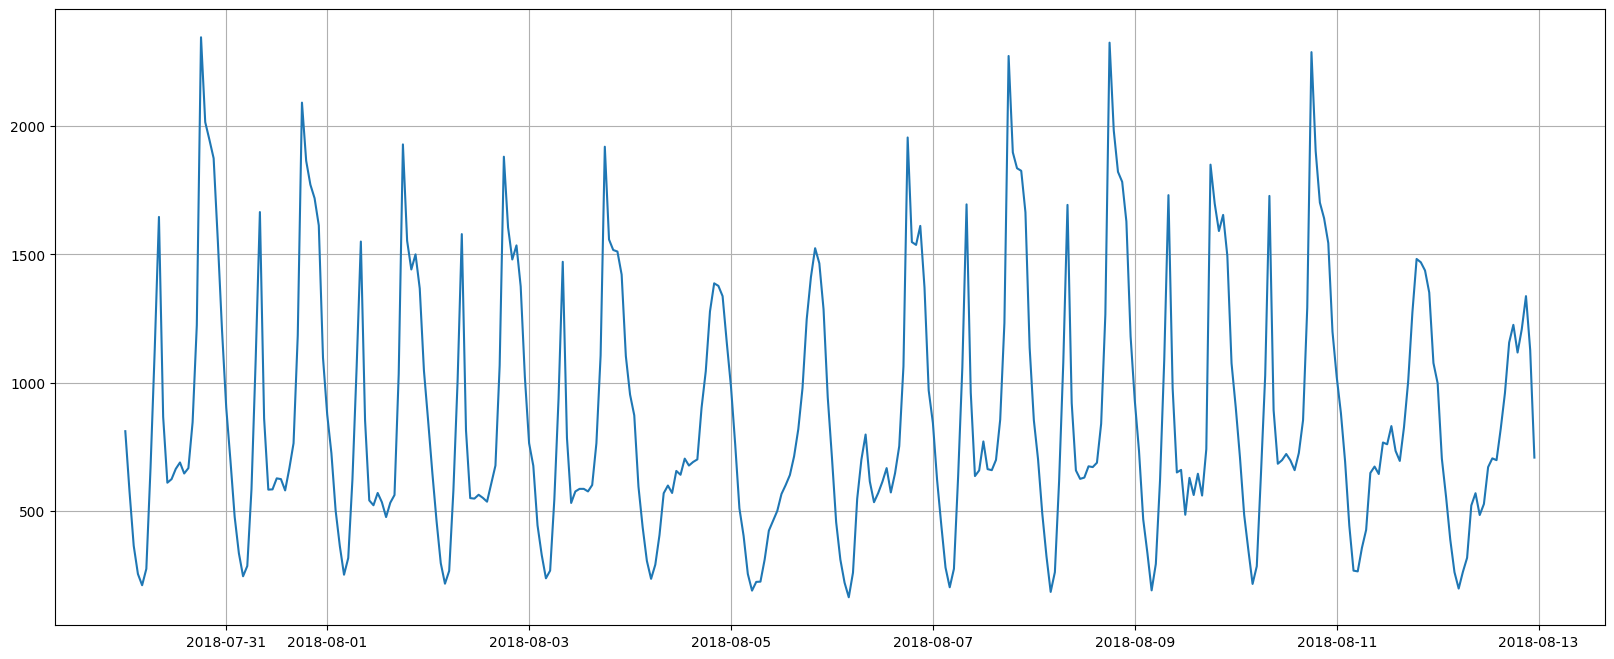

In [5]:
# 마지막 14일의 그래프를 그려 봅시다.
size = 24 * 14
temp = bike.iloc[-size:]
plt.figure(figsize = (20,8))
plt.plot('Datetime', 'Count', data = temp)
plt.grid()
plt.show()

# 2.시계열 데이터 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 :
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 2시간 후의 수요량을 예측하고자 합니다.
    * 이를 위해 y를 어떻게 만들어야 할까요?

In [6]:
data = bike.copy()

In [7]:
data['y'] = data['Count'].shift(-2)
display(data.head())
display(data.tail())

,Datetime,Temperature,Humidity,Count,y
0,2018-06-11 00:00:00,20.3,58.0,918,353.0
1,2018-06-11 01:00:00,19.8,59.0,555,232.0
2,2018-06-11 02:00:00,19.2,60.0,353,194.0
3,2018-06-11 03:00:00,18.8,61.0,232,324.0
4,2018-06-11 04:00:00,18.8,60.0,194,807.0


,Datetime,Temperature,Humidity,Count,y
1507,2018-08-12 19:00:00,32.0,76.0,1117,1337.0
1508,2018-08-12 20:00:00,29.4,86.0,1208,1127.0
1509,2018-08-12 21:00:00,28.9,83.0,1337,707.0
1510,2018-08-12 22:00:00,28.8,79.0,1127,NaN
1511,2018-08-12 23:00:00,28.7,81.0,707,NaN


In [8]:
# 제일 마지막 행은 삭제
data = data.iloc[:-2]

## (2) NaN 조치
* 시계열 데이터 NaN 조치 방법
    * 1) 이전값으로 채우기
    * 2) 보간법(앞,뒤 값으로 채우기)


* nan 확인

In [9]:
data.isna().sum()

Datetime       0
Temperature    3
Humidity       3
Count          0
y              0
dtype: int64

* 1) 이전값으로 채우기

In [10]:
data.loc[data['Temperature'].isna()]

,Datetime,Temperature,Humidity,Count,y
1392,2018-08-08 00:00:00,NaN,77.0,853,489.0
1393,2018-08-08 01:00:00,NaN,80.0,700,322.0
1394,2018-08-08 02:00:00,NaN,84.0,489,183.0


In [11]:
# NaN 조회
data.iloc[1390:1400]

,Datetime,Temperature,Humidity,Count,y
1390,2018-08-07 22:00:00,29.8,75.0,1664,853.0
1391,2018-08-07 23:00:00,29.5,78.0,1136,700.0
1392,2018-08-08 00:00:00,NaN,77.0,853,489.0
1393,2018-08-08 01:00:00,NaN,80.0,700,322.0
1394,2018-08-08 02:00:00,NaN,84.0,489,183.0
1395,2018-08-08 03:00:00,28.3,84.0,322,260.0
1396,2018-08-08 04:00:00,28.0,85.0,183,614.0
1397,2018-08-08 05:00:00,27.9,84.0,260,1079.0
1398,2018-08-08 06:00:00,27.6,84.0,614,1693.0
1399,2018-08-08 07:00:00,28.2,82.0,1079,920.0


In [12]:
# 채운 것처럼 조회(실제 값이 변경되지 않았음.)
data.fillna(method = 'ffill').iloc[1390:1400]

,Datetime,Temperature,Humidity,Count,y
1390,2018-08-07 22:00:00,29.8,75.0,1664,853.0
1391,2018-08-07 23:00:00,29.5,78.0,1136,700.0
1392,2018-08-08 00:00:00,29.5,77.0,853,489.0
1393,2018-08-08 01:00:00,29.5,80.0,700,322.0
1394,2018-08-08 02:00:00,29.5,84.0,489,183.0
1395,2018-08-08 03:00:00,28.3,84.0,322,260.0
1396,2018-08-08 04:00:00,28.0,85.0,183,614.0
1397,2018-08-08 05:00:00,27.9,84.0,260,1079.0
1398,2018-08-08 06:00:00,27.6,84.0,614,1693.0
1399,2018-08-08 07:00:00,28.2,82.0,1079,920.0


In [13]:
# 실제 적용
data.fillna(method = 'ffill', inplace = True)
data.iloc[1390:1400]

,Datetime,Temperature,Humidity,Count,y
1390,2018-08-07 22:00:00,29.8,75.0,1664,853.0
1391,2018-08-07 23:00:00,29.5,78.0,1136,700.0
1392,2018-08-08 00:00:00,29.5,77.0,853,489.0
1393,2018-08-08 01:00:00,29.5,80.0,700,322.0
1394,2018-08-08 02:00:00,29.5,84.0,489,183.0
1395,2018-08-08 03:00:00,28.3,84.0,322,260.0
1396,2018-08-08 04:00:00,28.0,85.0,183,614.0
1397,2018-08-08 05:00:00,27.9,84.0,260,1079.0
1398,2018-08-08 06:00:00,27.6,84.0,614,1693.0
1399,2018-08-08 07:00:00,28.2,82.0,1079,920.0


### 실습 : y만들기, NaN 조치

In [45]:
temp = bike.copy()

* 1) 5시간 후를 예측하기 위한 y를 만들어 봅시다.

In [46]:
temp.head()

,Datetime,Temperature,Humidity,Count
0,2018-06-11 00:00:00,20.3,58.0,918
1,2018-06-11 01:00:00,19.8,59.0,555
2,2018-06-11 02:00:00,19.2,60.0,353
3,2018-06-11 03:00:00,18.8,61.0,232
4,2018-06-11 04:00:00,18.8,60.0,194


In [47]:
temp['y'] = temp['Count'].shift(-5)
temp.head(10)

,Datetime,Temperature,Humidity,Count,y
0,2018-06-11 00:00:00,20.3,58.0,918,324.0
1,2018-06-11 01:00:00,19.8,59.0,555,807.0
2,2018-06-11 02:00:00,19.2,60.0,353,1629.0
3,2018-06-11 03:00:00,18.8,61.0,232,2375.0
4,2018-06-11 04:00:00,18.8,60.0,194,1307.0
5,2018-06-11 05:00:00,18.8,61.0,324,992.0
6,2018-06-11 06:00:00,18.6,61.0,807,1107.0
7,2018-06-11 07:00:00,19.1,59.0,1629,1204.0
8,2018-06-11 08:00:00,20.7,55.0,2375,1033.0
9,2018-06-11 09:00:00,22.2,48.0,1307,1075.0


* 2) NaN에 대해서 선형 보간법으로 채워봅시다.
    * .interpolate(method = 'linear')
    * 날짜 타입 칼럼 있으면 오류 발생. ==> 날짜를 제외하고 수행해야 함.

In [48]:
temp.isna().sum()

Datetime       0
Temperature    3
Humidity       3
Count          0
y              5
dtype: int64

In [49]:
# y의 5건은 삭제
temp = temp.iloc[:-5]
temp.isna().sum()

Datetime       0
Temperature    3
Humidity       3
Count          0
y              0
dtype: int64

In [52]:
temp[['Temperature','Humidity','Count','y']].interpolate().iloc[1390:1400]

,Temperature,Humidity,Count,y
1390,29.8,75.0,1664,322.0
1391,29.5,78.0,1136,183.0
1392,29.2,77.0,853,260.0
1393,28.9,80.0,700,614.0
1394,28.6,84.0,489,1079.0
1395,28.3,84.0,322,1693.0
1396,28.0,85.0,183,920.0
1397,27.9,84.0,260,657.0
1398,27.6,84.0,614,624.0
1399,28.2,82.0,1079,629.0


In [53]:
temp[['Temperature','Humidity']] = temp[['Temperature','Humidity']].interpolate()
temp.iloc[1390:1400]

,Datetime,Temperature,Humidity,Count,y
1390,2018-08-07 22:00:00,29.8,75.0,1664,322.0
1391,2018-08-07 23:00:00,29.5,78.0,1136,183.0
1392,2018-08-08 00:00:00,29.2,77.0,853,260.0
1393,2018-08-08 01:00:00,28.9,80.0,700,614.0
1394,2018-08-08 02:00:00,28.6,84.0,489,1079.0
1395,2018-08-08 03:00:00,28.3,84.0,322,1693.0
1396,2018-08-08 04:00:00,28.0,85.0,183,920.0
1397,2018-08-08 05:00:00,27.9,84.0,260,657.0
1398,2018-08-08 06:00:00,27.6,84.0,614,624.0
1399,2018-08-08 07:00:00,28.2,82.0,1079,629.0


## (3) 데이터 분할

### 1) x, y 나누기

In [22]:
data.head()

,Datetime,Temperature,Humidity,Count,y
0,2018-06-11 00:00:00,20.3,58.0,918,353.0
1,2018-06-11 01:00:00,19.8,59.0,555,232.0
2,2018-06-11 02:00:00,19.2,60.0,353,194.0
3,2018-06-11 03:00:00,18.8,61.0,232,324.0
4,2018-06-11 04:00:00,18.8,60.0,194,807.0


In [23]:
target = 'y'

x = data.drop([target, 'Datetime'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* train_test_split( x, y, test_size = , shuffle = False)
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기

In [24]:
# 마지막 3주간의 데이터를 검증셋으로 사용 : 24시간 * 21일
size = 24 * 21
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = size, shuffle = False)

# 3.Baseline 모델

## (1) 모델링

In [32]:
y_train

0        353.0
1        232.0
2        194.0
3        324.0
4        807.0
         ...  
1001    1478.0
1002    1688.0
1003    1666.0
1004    1346.0
1005    1030.0
Name: y, Length: 1006, dtype: float64

In [25]:
# 아래 문법은 다음 챕터에서 배우니 여기서는 신경쓰지 맙시다.
model1 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit()

In [27]:
# AIC 평가
model1.aic

14701.423755199974

## (2) 검증

In [28]:
pred1 = model1.forecast(size)

print('MAE  : ', mean_absolute_error(y_val, pred1))
print('MAPE : ', mean_absolute_percentage_error(y_val, pred1))
print('R2   : ', r2_score(y_val, pred1))

MAE  :  436.7631826753904
MAPE :  0.758704578107088
R2   :  -0.023668888936701604


## (3) 결과 시각화

* pred를 시리즈로 바꾸고, 인덱스 맞추기

In [29]:
pred1 = pd.Series(pred1, index = y_val.index)

* y_train, y_val(전체), pred 한꺼번에 시각화

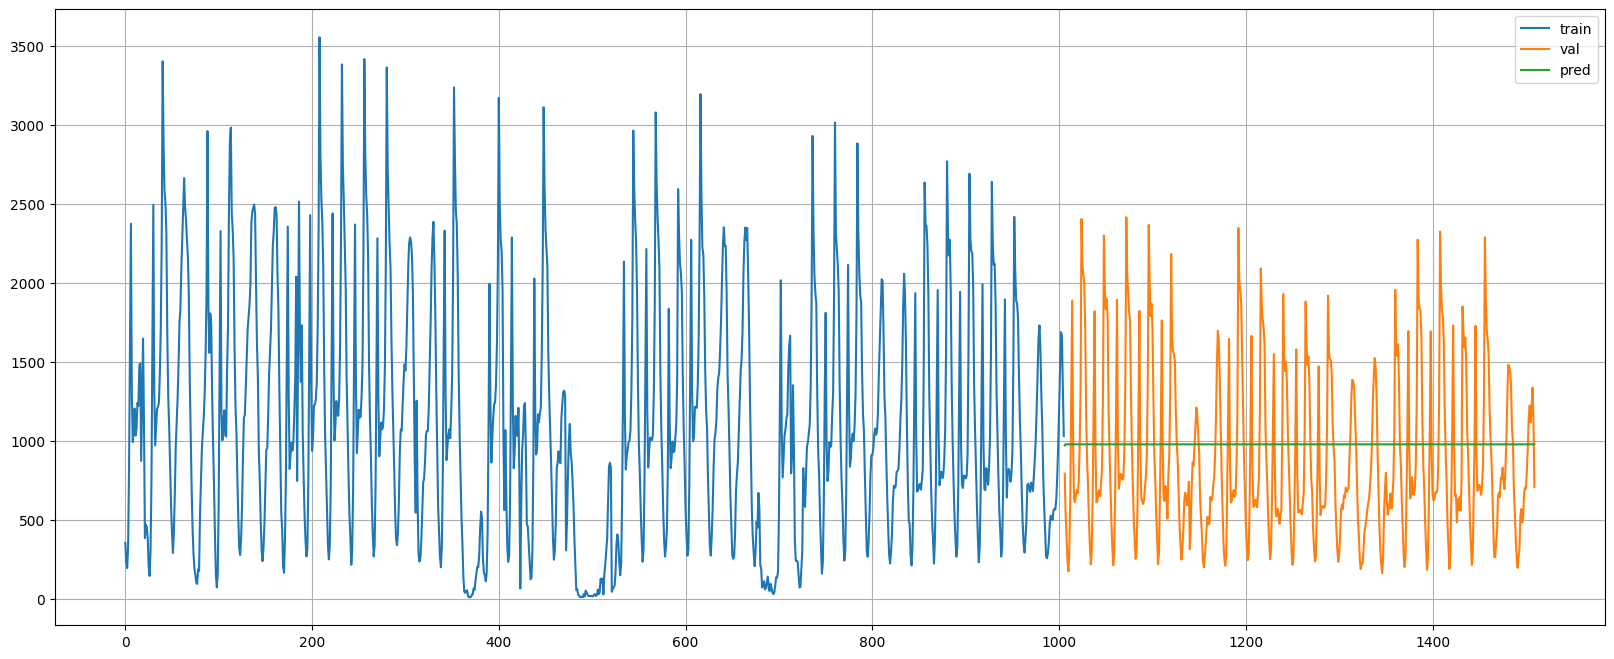

In [30]:
plt.figure(figsize = (20,8))
plt.plot(y_train, label = 'train')
plt.plot(y_val, label = 'val')
plt.plot(pred1, label = 'pred')

plt.legend()
plt.grid()
plt.show()

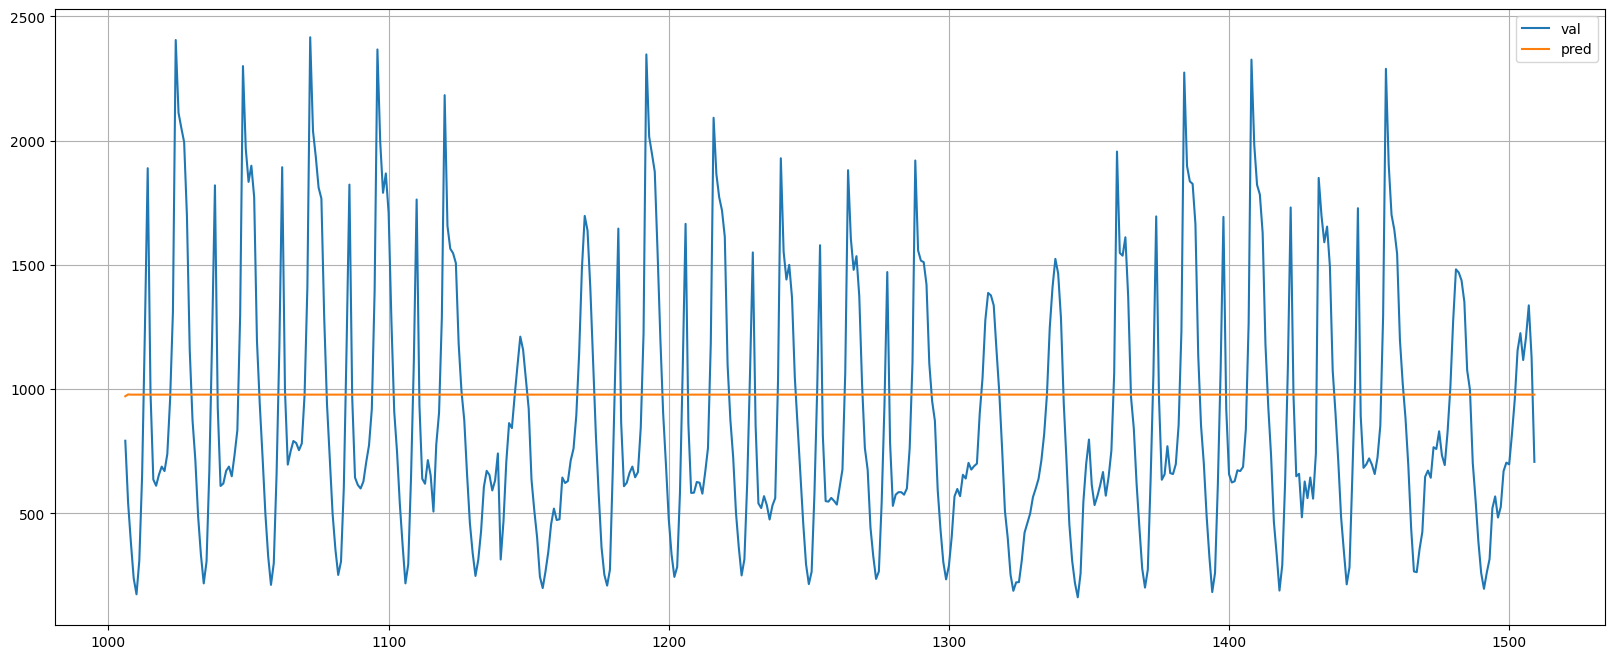

In [31]:
plt.figure(figsize = (20,8))
plt.plot(y_val, label = 'val')
plt.plot(pred1, label = 'pred')

plt.legend()
plt.grid()
plt.show()

# 4.평가 : 잔차분석

* 잔차에 대한 우리의 기대 : 화이트 노이즈
    * 자기상관성 없음 : ACF, PACF 그래프
    * 정규분포 : Shapiro-Wilk 검정
    * 평균과 분산이 일정(Stationary) : ADF 검정
* 만약 화이트 노이즈가 아니라면...
    * 더 찾아내야 할 패턴이 있다는 의미.

## (1) ACF, PACF

* 정상 데이터 및 자기상관관계가 없는 데이터라면
* ACF, PACF 그래프에서
    * 첫번째 lag 에서부터 하늘색 범위 안에 값이 위치해야 하고
    * 값의 등락에 대한 어떠한 패턴도 보이지 않아야 합니다.
* 그러나 실제 데이터에서는 그런 결과를 보기 쉽지 않습니다.

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [55]:
residuals = model1.resid

In [56]:
residuals

0       353.000000
1      -132.882011
2        -0.437589
3       125.449166
4       445.437265
           ...    
1001    209.819691
1002    152.992079
1003    -61.568272
1004   -296.285598
1005   -228.567329
Length: 1006, dtype: float64

### 1) ACF(자기 상관함수)

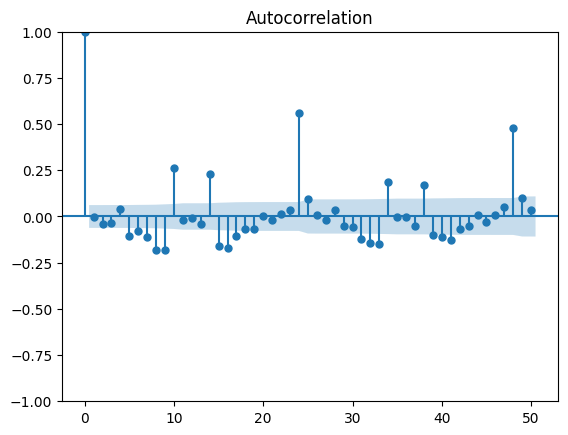

In [57]:
plot_acf(residuals, lags = 50)
plt.show()

In [58]:
# 반복문으로 시차를 늘려가면서 데이터셋 만들기
res_df = pd.DataFrame({'residuals':residuals})

for i in range(1,21) :
    var = 'lag' + str(i)
    res_df[var] = res_df['residuals'].shift(i)

In [ ]:
res_df.head(20)

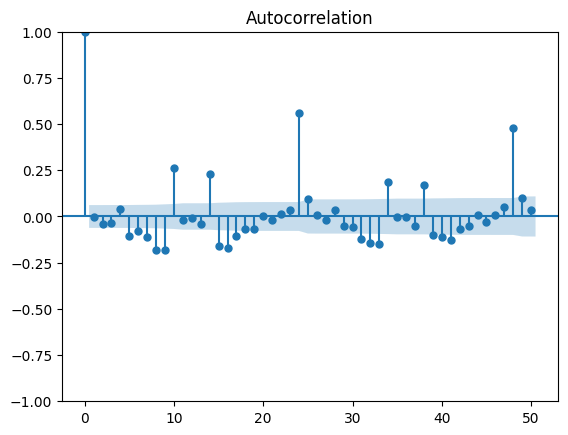

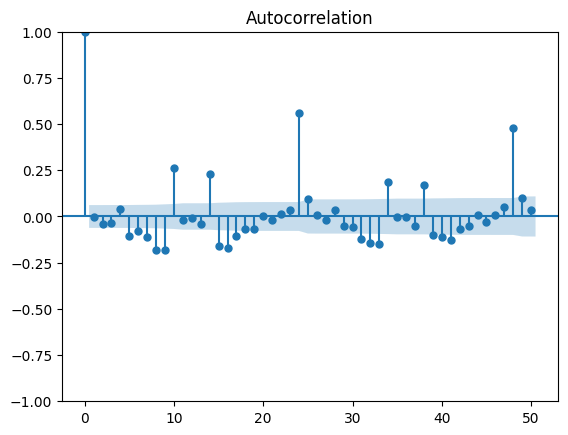

In [61]:
plot_acf(residuals, lags = 50)

In [60]:
# 각 시차간의 상관계수
res_df.corr()

,residuals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20
residuals,1.000000,-0.004369,-0.039836,-0.035703,0.040064,-0.103926,-0.077731,-0.113929,-0.181698,-0.182107,...,-0.021623,-0.008033,-0.040115,0.230459,-0.161539,-0.175055,-0.104636,-0.069315,-0.066846,0.002955
lag1,-0.004369,1.000000,-0.004889,-0.039954,-0.035450,0.040441,-0.103613,-0.077478,-0.113752,-0.181624,...,0.267505,-0.021512,-0.008071,-0.040137,0.230544,-0.161409,-0.174972,-0.104625,-0.069292,-0.067095
lag2,-0.039836,-0.004889,1.000000,-0.005033,-0.039629,-0.034997,0.040916,-0.103298,-0.077240,-0.113645,...,-0.182232,0.267751,-0.021566,-0.008092,-0.040102,0.230849,-0.161310,-0.174989,-0.104612,-0.069621
lag3,-0.035703,-0.039954,-0.005033,1.000000,-0.004961,-0.039536,-0.034906,0.040996,-0.103249,-0.077212,...,-0.181690,-0.182206,0.267746,-0.021570,-0.008082,-0.040058,0.230889,-0.161303,-0.174982,-0.104683
lag4,0.040064,-0.035450,-0.039629,-0.004961,1.000000,-0.005203,-0.039778,-0.035097,0.040865,-0.103335,...,-0.113642,-0.181787,-0.182198,0.267779,-0.021598,-0.008195,-0.040143,0.230889,-0.161343,-0.174855
lag5,-0.103926,0.040441,-0.034997,-0.039536,-0.005203,1.000000,-0.005525,-0.040042,-0.035293,0.040769,...,-0.077214,-0.113769,-0.181785,-0.182217,0.267790,-0.021757,-0.008308,-0.040180,0.230894,-0.161169
lag6,-0.077731,-0.103613,0.040916,-0.034906,-0.039778,-0.005525,1.000000,-0.005770,-0.040232,-0.035398,...,-0.103352,-0.077330,-0.113755,-0.181802,-0.182280,0.267693,-0.021868,-0.008338,-0.040220,0.231151
lag7,-0.113929,-0.077478,-0.103298,0.040996,-0.035097,-0.040042,-0.005770,1.000000,-0.005915,-0.040315,...,0.040792,-0.103445,-0.077312,-0.113757,-0.181847,-0.182422,0.267639,-0.021893,-0.008365,-0.040064
lag8,-0.181698,-0.113752,-0.077240,-0.103249,0.040865,-0.035293,-0.040232,-0.005915,1.000000,-0.005974,...,-0.035394,0.040735,-0.103432,-0.077310,-0.113784,-0.181951,-0.182499,0.267637,-0.021914,-0.008245
lag9,-0.182107,-0.181624,-0.113645,-0.077212,-0.103335,0.040769,-0.035398,-0.040315,-0.005974,1.000000,...,-0.040313,-0.035428,0.040746,-0.103430,-0.077322,-0.113839,-0.181992,-0.182512,0.267632,-0.021849


### 2) PACF

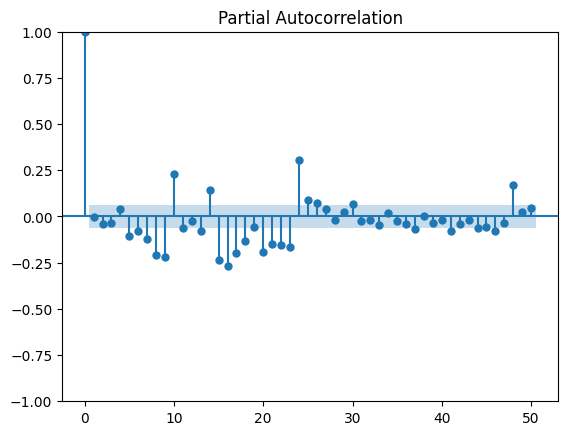

In [62]:
plot_pacf(residuals, lags = 50)
plt.show()

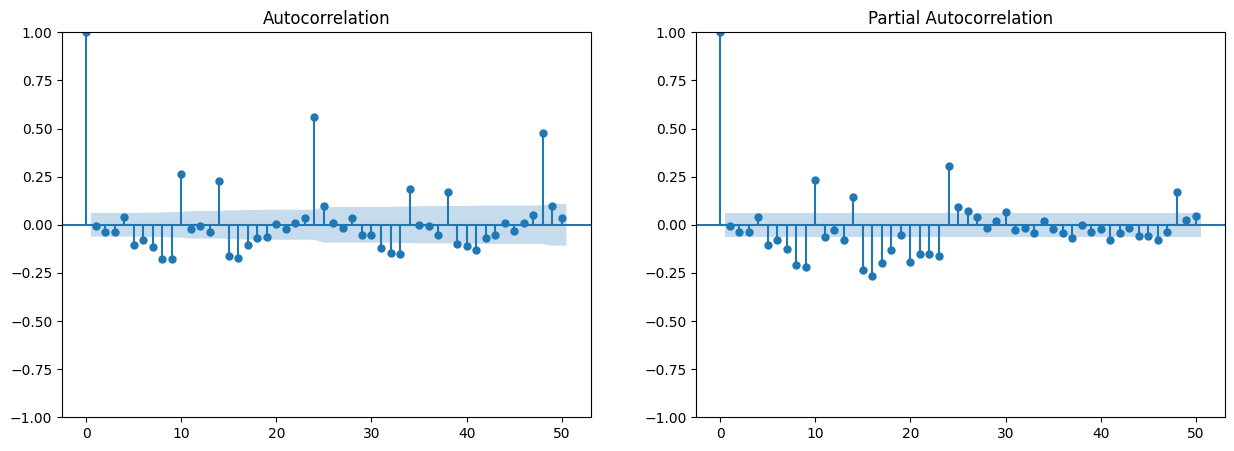

In [63]:
# ACF, PACF를 한꺼번에 그려 봅시다.
lags = 50

fig,ax = plt.subplots(1,2, figsize = (15,5))
plot_acf(residuals, lags = lags, ax = ax[0])
plot_pacf(residuals, lags = lags, ax = ax[1])
plt.show()

## (2) 검정
검정 도구를 적용하여 의사결정하는 용도로만 사용합니다.

In [64]:
import scipy.stats as spst
import statsmodels.api as sm

### 1) 정규성 검정 : Shapiro-Wilk 검정

* 귀무가설 : **정규 분포이다.** (p-value > 0.05)
* 대립가설 : 정규분포가 아니다.

In [65]:
spst.shapiro(residuals)[1]

1.2079655858832921e-23

### 2) 정상성 검정 : ADF 검정

* 귀무가설 : 비정상(Non-Stationary) 데이터이다.
* 대립가설 : **정상(Stationary) 데이터**이다.(P-value <= 0.05)

In [66]:
# ADF 테스트
sm.tsa.stattools.adfuller(residuals)[1]

3.3454164775253034e-30

# 5.함수로 만들기

* 자주 사용하게 될 코드를 함수로 생성합니다.
    * 결과 시각화
    * 잔차 분석

## (1) 결과 시각화

In [ ]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
plot_model_result(y_train, y_val, pred1)

## (2) 잔차분석

In [ ]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1], 5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1], 5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

In [ ]:
residual_diag(residuals, lags = 50)